# 1. Data Prep

## 1.1 Load Packages

In [17]:
## this is to be run in the terminal
# set up virtual environment
#python -m venv .env

#enable virtual environment
#.env\Scripts\activate

# install 
# pip install numpy pandas seaborn matplotlib tensorflow sklearn seaborn pydot graphviz statsmodels

In [18]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

import tensorflow as tf

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Concatenate, Dropout, Embedding, Flatten, Dense, BatchNormalization, LSTM, LSTM
import keras_tuner as kt
from keras.optimizers import Adam
import shap

from sklearn.metrics import  mean_squared_error, r2_score


## 1.2 Import Data

In [19]:
policy_claims = pd.read_csv('policy_claims.csv')
prop = policy_claims
lossofinc = policy_claims[policy_claims['LossofIncome_cover'] == True]

## 1.3 Data Pre-processing

- Split into training and test
- Separate targets and features

In [20]:
def pre_process(dataset, claimcount, grossincurred):
    # separate features out
    X = dataset.drop(['claimcount_prop', 'claimcount_lossofinc', 'grossincurred_prop', 'grossincurred_lossofinc', 'exposure', 'Unnamed: 0', 'date_weights', 'geo_code', 'building_info_na'], axis=1)
    y = pd.DataFrame(columns = ['frequency', 'severity'])
    y['frequency'] = dataset[claimcount] / dataset['exposure']
    y['severity'] = dataset[grossincurred] / dataset[claimcount]
    
    # division by 0 claim count will result in nan, replace with 0
    y= y.fillna(0)

    # split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    # collect identifying columns
    id_cols = ['policyno', 'situation_num', 'policy_version']
    train_id = X_train[id_cols]
    test_id = X_test[id_cols]
    X_train = X_train.drop(id_cols, axis=1)
    X_test = X_test.drop(id_cols, axis=1)

    return X_train, X_test, y_train, y_test, train_id, test_id

In [21]:
prop_Xtrain, prop_Xtest, prop_ytrain, prop_ytest, prop_train_id, prop_test_id = pre_process(prop, 'claimcount_prop', 'grossincurred_prop')
lossofinc_Xtrain, lossofinc_Xtest, lossofinc_ytrain, lossofinc_ytest, lossofinc_train_id, lossofinc_test_id = pre_process(lossofinc, 'claimcount_lossofinc', 'grossincurred_lossofinc')

Data Processing
- One-hot low dimensional categorical variables
- Min-max scale the nominal variables

In [22]:
def transform_data(X_train, X_test, y_train, y_test):
  NUM_OCCS, NUM_GEO = X_train.nunique()[["occupation_risk", "state"]]

  # transform features
  ct = make_column_transformer(
    (OrdinalEncoder(), ["occupation_risk", "state"]),
    (OneHotEncoder(drop = 'first'), ["construction_walls", "construction_floor", "sprinkler_type", "building_age", "building_type", "indem_per_grp"]),
    (MinMaxScaler(), ["suminsured_prop", "suminsured_lossofinc"]),
    remainder='passthrough',
    sparse_threshold=0
  )

  Xtrain_ct = ct.fit_transform(X_train)
  Xtest_ct = ct.transform(X_test)

  # transform targets
  ct_out = make_column_transformer(
  (MinMaxScaler(), ['frequency', 'severity']),
  remainder='passthrough',
  sparse_threshold=0
  )

  ytrain_ct = ct_out.fit_transform(y_train)
  ytest_ct = ct_out.transform(y_test)

  return Xtrain_ct, Xtest_ct, ytrain_ct, ytest_ct, NUM_GEO, NUM_OCCS


In [23]:
prop_Xtrain_ct, prop_Xtest_ct, prop_ytrain_ct, prop_ytest_ct, prop_NUM_GEO, prop_NUM_OCCS= transform_data(prop_Xtrain, prop_Xtest, prop_ytrain, prop_ytest)
lossofinc_Xtrain_ct, lossofinc_Xtest_ct, lossofinc_ytrain_ct, lossofinc_ytest_ct, lossofinc_NUM_GEO, lossofinc_NUM_OCCS = transform_data(lossofinc_Xtrain, lossofinc_Xtest, lossofinc_ytrain, lossofinc_ytest)

# 2. Building the Neural Network

Separate occupation_risk and geo_code from other inputs

In [24]:
def separate_embedding(data):
    # separate embedding features
    occs_train = data[:, 0].astype(np.float32)
    geos_train = data[:, 1].astype(np.float32)
    rest_train = data[:, 2:].astype(np.float32)
    
    return occs_train, geos_train, rest_train

In [25]:
prop_occs_train, prop_geos_train, prop_rest_train = separate_embedding(prop_Xtrain_ct)
prop_occs_test, prop_geos_test, prop_rest_test = separate_embedding(prop_Xtest_ct)

lossofinc_occs_train, lossofinc_geos_train, lossofinc_rest_train = separate_embedding(lossofinc_Xtrain_ct)
lossofinc_occs_test, lossofinc_geos_test, lossofinc_rest_test = separate_embedding(lossofinc_Xtest_ct)

Define the model

In [26]:
def model_builder_prop(hp):
    layers = hp.Int('layers', 1, 3)
    occ_embedding = hp.Choice('occ_embedding', [2,3,5])
    geocode_embedding = hp.Choice('geo_embedding', [2,3,5])
    activation = hp.Choice('activation', ['relu', 'LeakyReLU'])

    occupation_risk_input = Input(shape=(1,), name = "occupation_risk_input")
    geo_code_input = Input(shape=(1,), name = "geo_code_input")
    other_inputs = Input(shape = prop_rest_train.shape[1:], name = "other_inputs")
    
    occEE = Embedding(input_dim = prop_NUM_OCCS, output_dim = occ_embedding, name = "occEE")(occupation_risk_input)
    occEE = Flatten()(occEE)

    geoEE = Embedding(input_dim = prop_NUM_GEO, output_dim = geocode_embedding, name = "geoEE")(geo_code_input)
    geoEE = Flatten()(geoEE)

    features = Concatenate(name = "Combined")([occEE, geoEE, other_inputs])

    x = features
    for i in range(layers + 1):
        x = Dense(units = hp.Float(f'neurons{i}', 50, 500, step = 50), activation = activation , name = f"hidden{i}")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
    concat = Concatenate(name = "combined")([x, features])
    
    frequency_out = Dense(1, activation = "linear", name = "frequency")(concat)
    severity_out = Dense(1, activation = "linear", name = "severity")(concat)

    DenseModel = Model(inputs = [occupation_risk_input, geo_code_input, other_inputs],
                       outputs = [frequency_out, severity_out]) 
    
    DenseModel.compile(optimizer = "adam", 
                       loss={'frequency': 'mean_squared_error', 'severity': 'mean_squared_error'}, 
                       metrics = ('accuracy'))

    return DenseModel

In [27]:
def model_builder_lossofinc(hp):
    layers = hp.Int('layers', 1, 3)
    occ_embedding = hp.Choice('occ_embedding', [2,3,5])
    geocode_embedding = hp.Choice('geo_embedding', [2,3,5])
    activation = hp.Choice('activation', ['relu', 'LeakyReLU'])
    
    occupation_risk_input = Input(shape=(1,), name = "occupation_risk_input")
    geo_code_input = Input(shape=(1,), name = "geo_code_input")
    other_inputs = Input(shape = lossofinc_rest_train.shape[1:], name = "other_inputs")
    
    occEE = Embedding(input_dim = lossofinc_NUM_OCCS, output_dim = occ_embedding, name = "occEE")(occupation_risk_input)
    occEE = Flatten()(occEE)

    geoEE = Embedding(input_dim = lossofinc_NUM_GEO, output_dim = geocode_embedding, name = "geoEE")(geo_code_input)
    geoEE = Flatten()(geoEE)

    features = Concatenate(name = "Combined")([occEE, geoEE, other_inputs])

    x = features
    for i in range(layers + 1):
        x = Dense(units = hp.Float(f'neurons{i}', 50, 500, step = 50), activation = activation , name = f"hidden{i}")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
    concat = Concatenate(name = "combined")([x, features])
    
    frequency_out = Dense(1, activation = "linear", name = "frequency")(concat)
    severity_out = Dense(1, activation = "linear", name = "severity")(concat)

    DenseModel = Model(inputs = [occupation_risk_input, geo_code_input, other_inputs],
                       outputs = [frequency_out, severity_out]) 
    
    DenseModel.compile(optimizer = "adam", 
                       loss={'frequency': 'mean_squared_error', 'severity': 'mean_squared_error'}, 
                       metrics = ('accuracy'))

    return DenseModel

Fit the model

In [28]:
tuner_prop = kt.BayesianOptimization(
    model_builder_prop, 
    objective = 'val_loss',
    max_trials = 15,
    overwrite = True,
    seed = 17,
    directory = "Prop")

In [29]:
tuner_lossofinc = kt.BayesianOptimization(
    model_builder_lossofinc, 
    objective = 'val_loss',
    max_trials = 15,
    overwrite = True,
    seed = 17,
    directory = "Lossofinc")

In [30]:
def fitmodel(tuner, occs_train, geos_train, rest_train, ytrain):
    es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

    tuner.search(
        (occs_train, geos_train, rest_train),
        ytrain,
        epochs = 50,
        validation_split = 0.2,
        callbacks = [es], 
        verbose = 1
    )

    tuner.results_summary()

    best_model = tuner.get_best_models()[0]
    best_params = tuner.get_best_hyperparameters()[0]

    hist = best_model.fit(
        (occs_train, geos_train, rest_train), 
        ytrain, 
        epochs = 50,
        validation_split = 0.2,
        callbacks = [es], 
        verbose = 1
    )

    return best_model, best_params, hist

In [31]:
bestpropmodel, bestpropparams, prophist = fitmodel(tuner_prop, prop_occs_train, prop_geos_train, prop_rest_train, prop_ytrain_ct)

Trial 15 Complete [00h 03m 20s]
val_loss: 0.00042944986489601433

Best val_loss So Far: 0.000426340353442356
Total elapsed time: 00h 53m 15s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in Prop\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 2
occ_embedding: 5
geo_embedding: 3
activation: relu
neurons0: 400.0
neurons1: 400.0
neurons2: 450.0
neurons3: 450.0
Score: 0.000426340353442356
Trial summary
Hyperparameters:
layers: 2
occ_embedding: 5
geo_embedding: 5
activation: relu
neurons0: 100.0
neurons1: 500.0
neurons2: 450.0
neurons3: 500.0
Score: 0.0004270161734893918
Trial summary
Hyperparameters:
layers: 2
occ_embedding: 5
geo_embedding: 2
activation: LeakyReLU
neurons0: 100.0
neurons1: 300.0
neurons2: 450.0
neurons3: 400.0
Score: 0.0004270767676644027
Trial summary
Hyperparameters:
layers: 3
occ_embedding: 5
geo_embedding: 3
activation: relu
neurons0: 350.0
neurons1: 100.0
neurons2: 300.0
neurons3: 50.0
Score: 0.0004271436482667923
Trial 

In [32]:
bestlossofincmodel, bestlossofincparams, lossofinchist = fitmodel(tuner_lossofinc, lossofinc_occs_train, lossofinc_geos_train, lossofinc_rest_train, lossofinc_ytrain_ct)

Trial 15 Complete [00h 09m 02s]
val_loss: 0.00021543986804317683

Best val_loss So Far: 0.00021475266839843243
Total elapsed time: 01h 20m 01s
INFO:tensorflow:Oracle triggered exit


Results summary
Results in Lossofinc\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 2
occ_embedding: 5
geo_embedding: 2
activation: relu
neurons0: 200.0
neurons1: 500.0
neurons2: 300.0
neurons3: 200.0
Score: 0.00021475266839843243
Trial summary
Hyperparameters:
layers: 3
occ_embedding: 5
geo_embedding: 3
activation: relu
neurons0: 350.0
neurons1: 100.0
neurons2: 300.0
neurons3: 50.0
Score: 0.00021478673443198204
Trial summary
Hyperparameters:
layers: 1
occ_embedding: 5
geo_embedding: 2
activation: LeakyReLU
neurons0: 450.0
neurons1: 500.0
neurons2: 100.0
neurons3: 450.0
Score: 0.00021480637951754034
Trial summary
Hyperparameters:
layers: 1
occ_embedding: 5
geo_embedding: 3
activation: relu
neurons0: 400.0
neurons1: 300.0
neurons2: 100.0
neurons3: 150.0
Score: 0.00021496502449736
Trial summary
Hyperparameters:
layers: 2
occ_embedding: 5
geo_embedding: 5
activation: relu
neurons0: 150.0
neurons1: 150.0
neurons2: 200.0
neurons3: 450.0
Score: 0.0002150443324

Look into best selected models

In [33]:
def plot_history(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel('epoch')
    plt.ylabel('MSE Loss')

    plt.legend()
    plt.show()

In [34]:
bestpropmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 occupation_risk_input (InputLa  [(None, 1)]         0           []                               
 yer)                                                                                             
                                                                                                  
 geo_code_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 occEE (Embedding)              (None, 1, 5)         95          ['occupation_risk_input[0][0]']  
                                                                                                  
 geoEE (Embedding)              (None, 1, 3)         24          ['geo_code_input[0][0]']     

In [35]:
bestpropparams.values


{'layers': 2,
 'occ_embedding': 5,
 'geo_embedding': 3,
 'activation': 'relu',
 'neurons0': 400.0,
 'neurons1': 400.0,
 'neurons2': 450.0,
 'neurons3': 450.0}

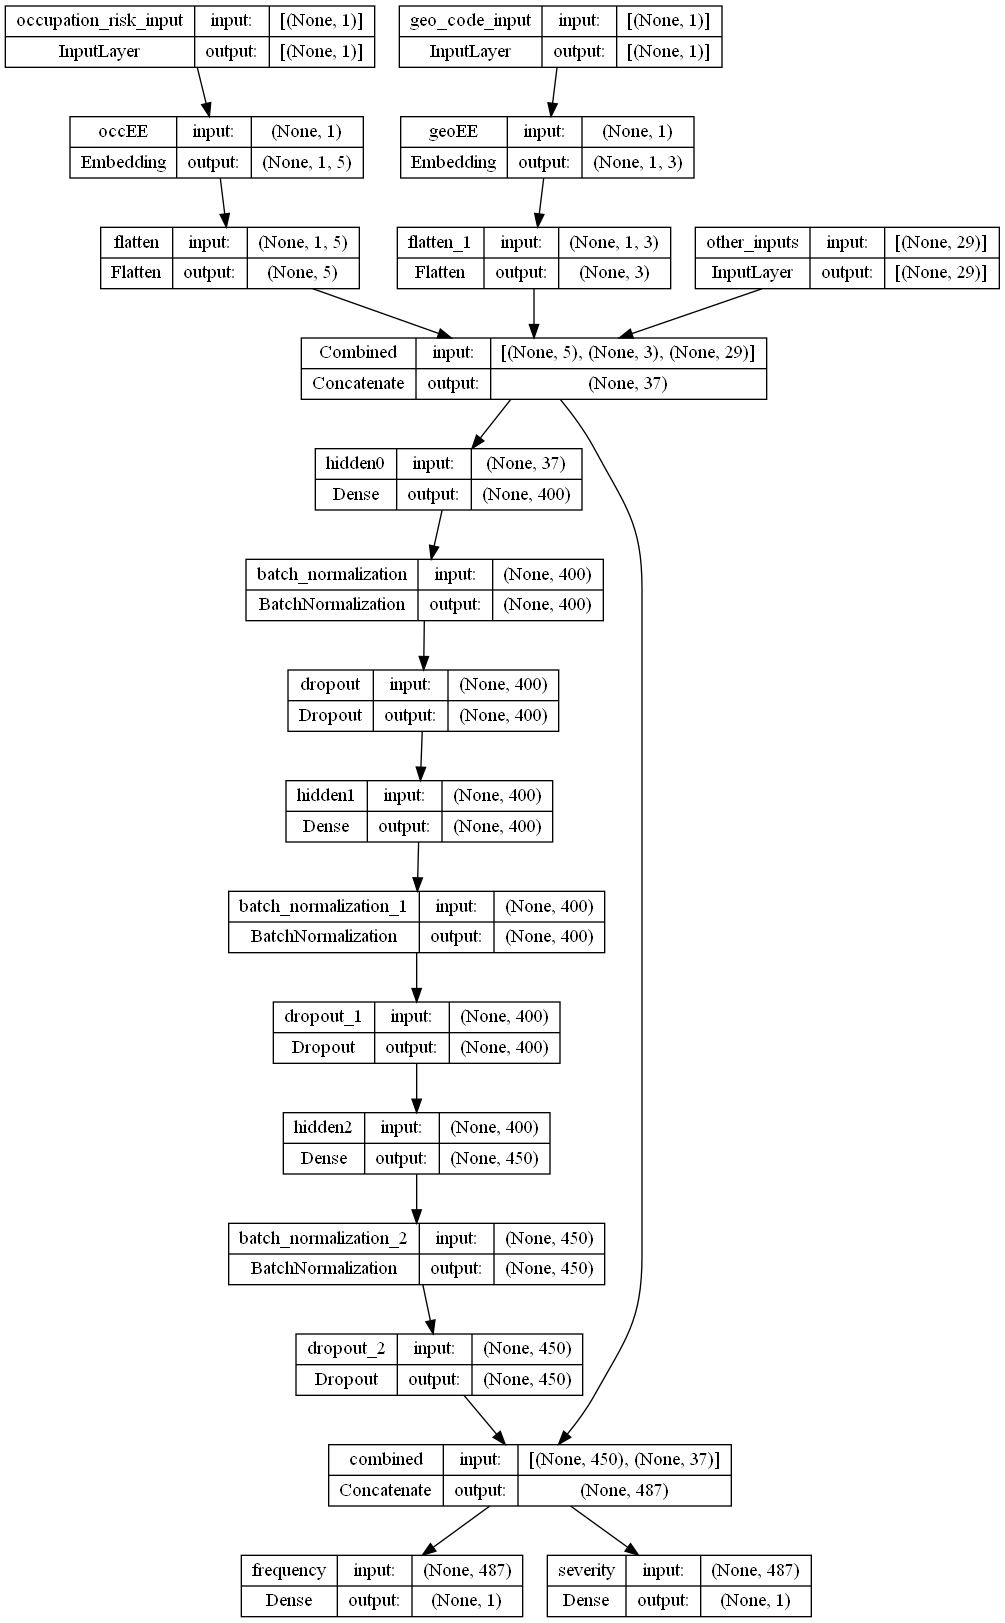

In [36]:
plot_model(bestpropmodel, show_shapes=True)


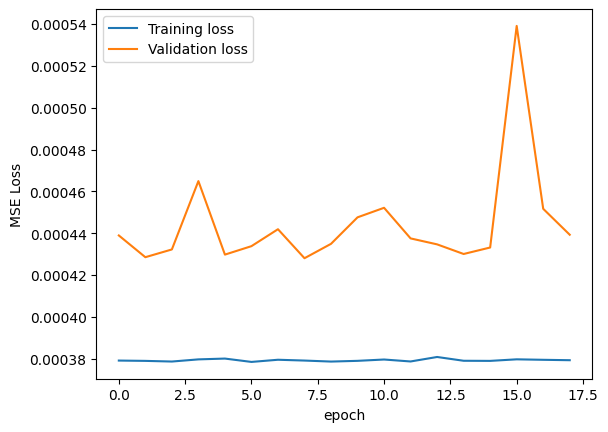

In [37]:
plot_history(prophist)

In [38]:
bestlossofincmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 occupation_risk_input (InputLa  [(None, 1)]         0           []                               
 yer)                                                                                             
                                                                                                  
 geo_code_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 occEE (Embedding)              (None, 1, 5)         95          ['occupation_risk_input[0][0]']  
                                                                                                  
 geoEE (Embedding)              (None, 1, 2)         16          ['geo_code_input[0][0]']     

In [39]:
bestlossofincparams.values


{'layers': 2,
 'occ_embedding': 5,
 'geo_embedding': 2,
 'activation': 'relu',
 'neurons0': 200.0,
 'neurons1': 500.0,
 'neurons2': 300.0,
 'neurons3': 200.0}

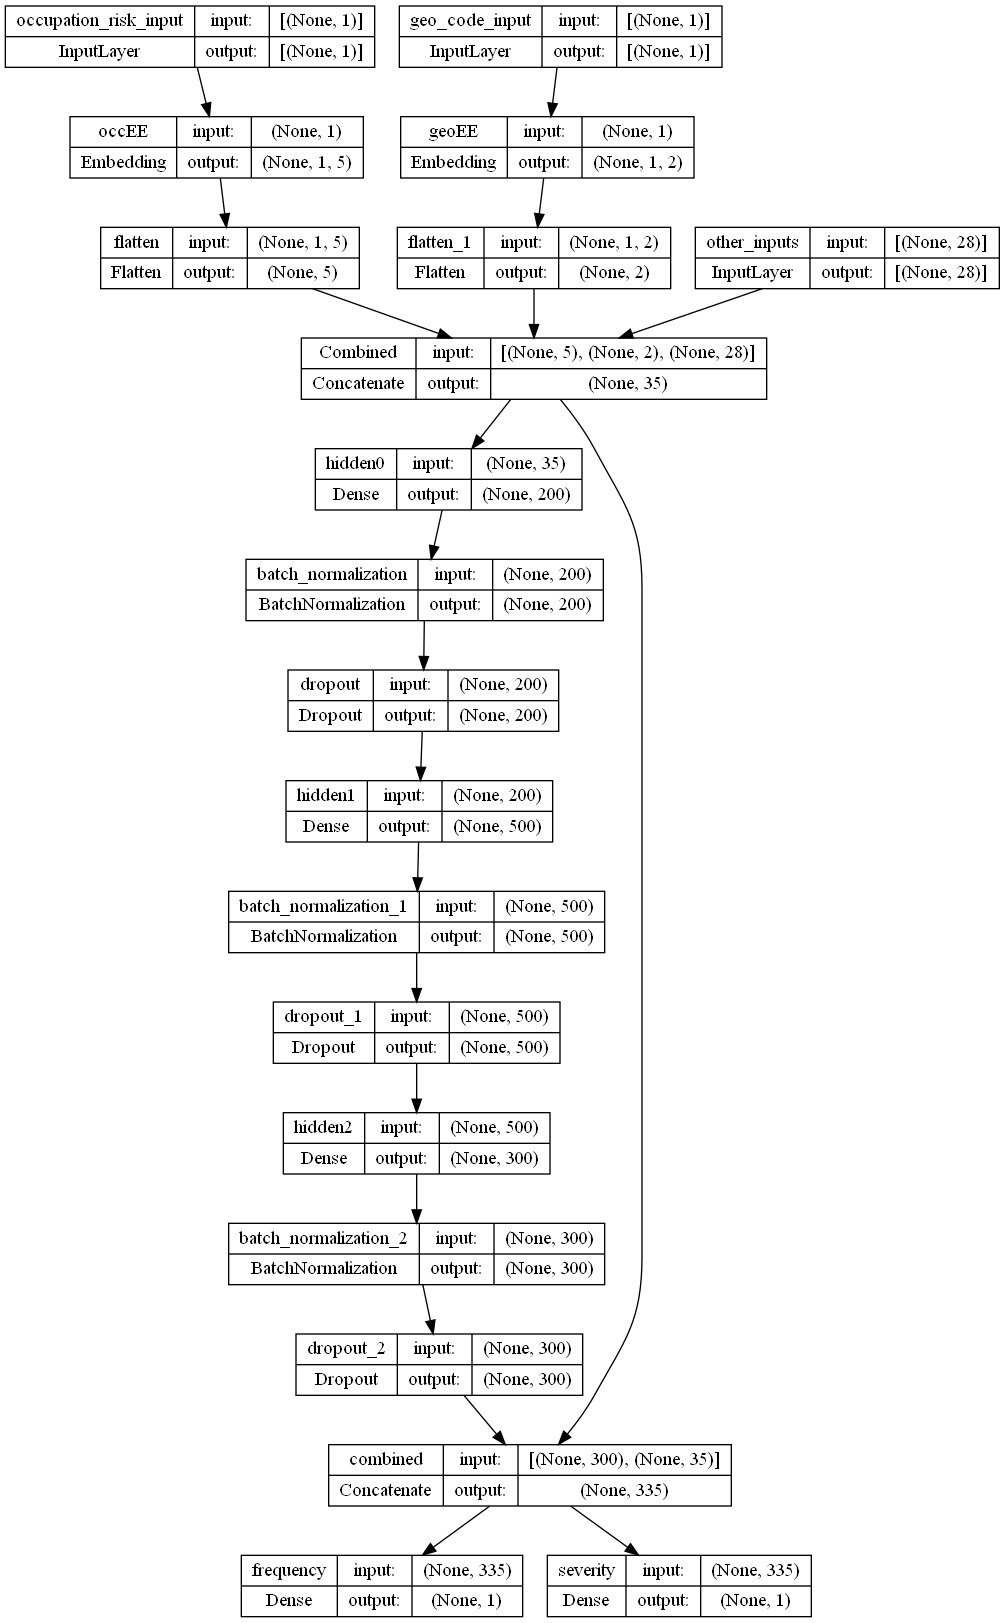

In [40]:
plot_model(bestlossofincmodel, show_shapes=True)

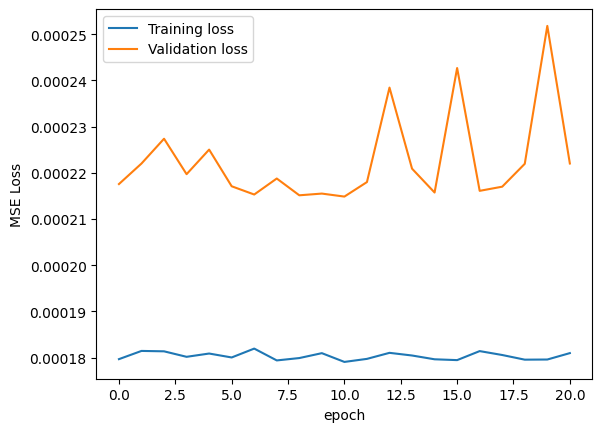

In [41]:
plot_history(lossofinchist)

## Model Predictions

Generate predictions

In [42]:
def rev_min_max_func(scaled_val, original_val):
    max_val = max(original_val)
    min_val = min(original_val)
    og_val = (scaled_val*(max_val - min_val)) + min_val
    return og_val

In [51]:
def nnPredictions(model, x_data, y_data, og_y_data):
    
    y = y_data
    freq_pred, sev_pred = model.predict(x_data)

    # compile predictions and actual values
    merge = pd.DataFrame({"pred_freq": freq_pred.flatten(), "actual_freq": y[:,0], "pred_sev":sev_pred.flatten(), "actual_sev": y[:,1]})

    # undo min max scaler
    merge['pred_freq'] = rev_min_max_func(merge['pred_freq'], og_y_data.loc[:, "frequency"])
    merge['actual_freq'] = rev_min_max_func(merge['actual_freq'], og_y_data.loc[:, "frequency"])
    merge['pred_sev'] = rev_min_max_func(merge['pred_sev'], og_y_data.loc[:, "severity"])
    merge['actual_sev'] = rev_min_max_func(merge['actual_sev'], og_y_data.loc[:, "severity"])

    # pure premium
    merge['pred_pure_premium'] = merge['pred_freq'] * merge['pred_sev']
    merge['actual_pure_premium'] = merge['actual_freq'] * merge['actual_sev']

    # residuals
    merge['freq_residual'] = merge['pred_freq'] - merge['actual_freq']
    merge['sev_residual'] = merge['pred_sev'] - merge['actual_sev']
    merge['pure_premium_residual'] = merge['pred_pure_premium'] - merge['actual_pure_premium']

    return merge

In [52]:
prop_train_predictions = nnPredictions(bestpropmodel, (prop_occs_train, prop_geos_train, prop_rest_train), prop_ytrain_ct, prop_ytrain)
lossofinc_train_predictions = nnPredictions(bestlossofincmodel, (lossofinc_occs_train, lossofinc_geos_train, lossofinc_rest_train), lossofinc_ytrain_ct, lossofinc_ytrain)

prop_test_predictions = nnPredictions(bestpropmodel, (prop_occs_test, prop_geos_test, prop_rest_test), prop_ytest_ct, prop_ytrain)
lossofinc_test_predictions = nnPredictions(bestlossofincmodel, (lossofinc_occs_test, lossofinc_geos_test, lossofinc_rest_test), lossofinc_ytest_ct, lossofinc_ytrain)


519/519 [==============================] - 2s 3ms/step


In [53]:
# merge predictions with ID 
prop_train_predictions.index = prop_train_id.index
prop_train_predictions_merged = pd.concat([prop_train_id, prop_train_predictions,], axis = 1)

lossofinc_train_predictions.index = lossofinc_train_id.index
lossofinc_train_predictions_merged = pd.concat([lossofinc_train_id, lossofinc_train_predictions], axis = 1)

prop_test_predictions.index = prop_test_id.index
prop_test_predictions_merged = pd.concat([prop_test_id, prop_test_predictions ], axis = 1)

lossofinc_test_predictions.index = lossofinc_test_id.index
lossofinc_test_predictions_merged = pd.concat([lossofinc_test_id, lossofinc_test_predictions], axis = 1)

# left join prop and loss of inc predictions on ID
train_predictions_merged = pd.merge(prop_train_predictions_merged, lossofinc_train_predictions_merged, how = "left", on = ['policyno', 'situation_num', 'policy_version'], suffixes=('_prop', '_lossofinc'))
test_predictions_merged = pd.merge(prop_test_predictions_merged, lossofinc_test_predictions_merged, how = "left", on = ['policyno', 'situation_num', 'policy_version'], suffixes=('_prop', '_lossofinc'))

# set missing to 0 - these are the policies with no loss of income cover
train_predictions_merged = train_predictions_merged.fillna(0)
test_predictions_merged = test_predictions_merged.fillna(0)

# calculate total premium
train_predictions_merged['pred_total_premium'] = train_predictions_merged['pred_pure_premium_prop'] + train_predictions_merged['pred_pure_premium_lossofinc']
train_predictions_merged['actual_total_premium'] = train_predictions_merged['actual_pure_premium_prop'] + train_predictions_merged['actual_pure_premium_lossofinc']
test_predictions_merged['pred_total_premium'] = test_predictions_merged['pred_pure_premium_prop'] + test_predictions_merged['pred_pure_premium_lossofinc']
test_predictions_merged['actual_total_premium'] = test_predictions_merged['actual_pure_premium_prop'] + test_predictions_merged['actual_pure_premium_lossofinc']

Calculate metrics

In [54]:
rmsePropFreqTrain= mean_squared_error(prop_train_predictions['pred_freq'], prop_train_predictions['actual_freq'], squared=False)
rmsePropSevTrain = mean_squared_error(prop_train_predictions['pred_sev'], prop_train_predictions['actual_sev'], squared=False)
rmsePropFreqTest = mean_squared_error(prop_test_predictions['pred_freq'], prop_test_predictions['actual_freq'], squared=False)
rmsePropSevTest = mean_squared_error(prop_test_predictions['pred_sev'], prop_test_predictions['actual_sev'], squared=False)
rmsePropPremTrain = mean_squared_error(prop_train_predictions['pred_pure_premium'], prop_train_predictions['actual_pure_premium'], squared=False)
rmsePropPremTest = mean_squared_error(prop_test_predictions['pred_pure_premium'], prop_test_predictions['actual_pure_premium'], squared=False)


print(f"Prop Train Freq RMSE: {rmsePropFreqTrain}")
print(f"Prop Train Sev RMSE: {rmsePropSevTrain}")
print(f"Prop Test Freq RMSE: {rmsePropFreqTest}")
print(f"Prop Test Sev RMSE: {rmsePropSevTest}")
print(f"Prop Train Pure Premium RMSE: {rmsePropPremTrain}")
print(f"Prop Test Pure Premium RMSE: {rmsePropPremTest}")


Prop Train Freq RMSE: 0.354804906110867
Prop Train Sev RMSE: 38792.04786291489
Prop Test Freq RMSE: 0.35671951473612545
Prop Test Sev RMSE: 19939.119644767292
Prop Train Pure Premium RMSE: 40521.678693336384
Prop Test Pure Premium RMSE: 13466.794707474153


In [55]:
rmseLossOfIncFreqTrain = mean_squared_error(lossofinc_train_predictions['pred_freq'], lossofinc_train_predictions['actual_freq'], squared=False)
rmseLossOfIncSevTrain = mean_squared_error(lossofinc_train_predictions['pred_sev'], lossofinc_train_predictions['actual_sev'], squared=False)
rmseLossOfIncFreqTest = mean_squared_error(lossofinc_test_predictions['pred_freq'], lossofinc_test_predictions['actual_freq'], squared=False)
rmseLossOfIncSevTest = mean_squared_error(lossofinc_test_predictions['pred_sev'], lossofinc_test_predictions['actual_sev'], squared=False)
rmseLossOfIncPremTrain = mean_squared_error(lossofinc_train_predictions['pred_pure_premium'], lossofinc_train_predictions['actual_pure_premium'], squared=False)
rmseLossOfIncPremTest = mean_squared_error(lossofinc_test_predictions['pred_pure_premium'], lossofinc_test_predictions['actual_pure_premium'], squared=False)

print(f"Loss of Inc Train Freq RMSE: {rmseLossOfIncFreqTrain}")
print(f"Loss of Inc Train Sev RMSE: {rmseLossOfIncSevTrain}")
print(f"Loss of Inc Test Freq RMSE: {rmseLossOfIncFreqTest}")
print(f"Loss of Inc Test Sev RMSE: {rmseLossOfIncSevTest}")
print(f"Loss of Inc Train Pure Premium RMSE: {rmseLossOfIncPremTrain}")
print(f"Loss of Inc Test Pure Premium RMSE: {rmseLossOfIncPremTest}")

Loss of Inc Train Freq RMSE: 0.06973130267138124
Loss of Inc Train Sev RMSE: 2682.076469755564
Loss of Inc Test Freq RMSE: 0.07263735024084236
Loss of Inc Test Sev RMSE: 3347.373163031235
Loss of Inc Train Pure Premium RMSE: 3573.4222892690314
Loss of Inc Test Pure Premium RMSE: 3432.1519272704645


In [56]:
rmseTotalPremiumsTrain = mean_squared_error(train_predictions_merged['pred_total_premium'], train_predictions_merged['actual_total_premium'], squared=False)
rmseTotalPremiumsTest = mean_squared_error(test_predictions_merged['pred_total_premium'], test_predictions_merged['actual_total_premium'], squared=False)

print(f"Total Premiums Train RMSE: {rmseTotalPremiumsTrain}")
print(f"Total Premiums Test RMSE: {rmseTotalPremiumsTest}")

Total Premiums Train RMSE: 42281.99007428928
Total Premiums Test RMSE: 13694.164645812107


def plotPredictions(data, model, datasplit, actual, pred, residuals):
    fig, ((ax1, ax2)) = plt.subplots(2,1, figsize=(8,10))

    plt.suptitle(f"{model} Prediction on {datasplit} Set")

    ax1.scatter(data[actual], data[pred])
    ax1.set_ylabel("Predictions")
    ax1.set_xlabel("True values")
    ax1.set_title(f"{model} {datasplit} Predictions vs Actual")
    
    xl = ax1.get_xlim()
    yl = ax1.get_ylim()
    shortestSide = min(xl[1], yl[1])
    ax1.plot(xl, yl, color="black", linestyle="--")

    sns.regplot(x = data[actual], y = data[residuals], data = None, scatter = True, ax=ax2, truncate = False)
    ax2.set_title(f"{model} {datasplit} Residuals vs Actual Values")

plotPredictions(prop_test_predictions, 'Test','Prop Frequency', 'actual_freq', 'pred_freq', 'freq_residual')
plotPredictions(prop_test_predictions, 'Test','Prop Severity', 'actual_sev', 'pred_sev', 'sev_residual')
plotPredictions(prop_test_predictions, 'Test','Prop Pure Premium', 'actual_total_premium', 'pred_total_premium', 'pure_premium_residual')
'actual_pure_premium'
plotPredictions(lossofinc_test_predictions, 'Test','Loss of Income Frequency', 'actual_freq', 'pred_freq', 'freq_residual')
plotPredictions(lossofinc_test_predictions, 'Test','Loss of Income  Severity', 'actual_sev', 'pred_sev', 'sev_residual')
plotPredictions(lossofinc_test_predictions, 'Test','Loss of Income Pure Premium', 'actual_total_premium', 'pred_total_premium', 'pure_premium_residual')

# Attempt at SHAP

The issue with applying SHAP on our model mainly lies in its nature as a multi-input multi-output model which is not supported by the SHAP package. More research needs to be performed to investigate this.

explainer = shap.explainers.Permutation(bestpropmodel, [prop_occs_train, prop_geos_train, prop_rest_train], max_evals = 1854721)
shap_values = explainer([prop_occs_test, prop_geos_test, prop_rest_test])

plot the SHAP values
shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[0])

shap.force_plot(explainer.expected_value, shap_values[0], prop_test.iloc[0,:])

shap_values = shap.DeepExplainer(bestpropmodel).shap_values([prop_occs_train, prop_geos_train, prop_rest_train])
shap.summary_plot(shap_values, [prop_occs_train, prop_geos_train, prop_rest_train], plot_type="bar")